This script trains the phoneme level model

In [2]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow_io==0.23.1
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# test GPU runtime
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# Imports
import os
import pandas as pd
import glob
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D


This script, unlike the word level script, contains all pre-processing within itself. Much of this code is re-used from the preprocessing script.

In [6]:
# Use glob module to create list of all files within the file defined in path
path = '/content/drive/My Drive/Colab Notebooks/SummerProject/data/labels-uxtd-uxssd-upx/uxtd/phone_labels/lab/'
all_files = glob.glob(os.path.join(path, "*.lab"))

In [7]:
# temp_li is a list of phenome start, phenome end, file path and phoneme
temp_li = []
x=0

for filename in all_files:
  x=x+1
  print(x)
  temp_df = pd.read_csv(filename, sep=' ', index_col=None, header=0)
  sess = filename[-8:-4]
  patient = filename[-12:-9]
  temp_df['filepath'] = "/content/drive/My Drive/Colab Notebooks/SummerProject/data/core-uxtd/core/"+patient+"/"+sess+".wav"
  temp_li.append(temp_df.values.tolist())


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
# convert temp_li to dataframe

li = [x for xs in temp_li for x in xs]
df = pd.DataFrame(li, columns = ['Start', 'End', 'Phoneme', 'filepath'])

df['End'] = df['End'] * (1*(10**-7))
df['End'] = df['End'].round(decimals=2)
df['Start'] = df['Start'] * (1*(10**-7))
df['Start'] = df['Start'].round(decimals=2)

In [9]:
df

,Start,End,Phoneme,filepath
0,0.76,1.79,S,/content/drive/My Drive/Colab Notebooks/Summer...
1,1.79,2.28,sil,/content/drive/My Drive/Colab Notebooks/Summer...
2,2.28,2.69,a,/content/drive/My Drive/Colab Notebooks/Summer...
3,2.69,2.95,S,/content/drive/My Drive/Colab Notebooks/Summer...
4,2.95,3.56,a,/content/drive/My Drive/Colab Notebooks/Summer...
...,...,...,...,...
26011,4.77,5.01,sil,/content/drive/My Drive/Colab Notebooks/Summer...
26012,5.01,5.68,@U,/content/drive/My Drive/Colab Notebooks/Summer...
26013,5.68,5.71,w,/content/drive/My Drive/Colab Notebooks/Summer...
26014,5.71,6.03,@U,/content/drive/My Drive/Colab Notebooks/Summer...


In [10]:
#Drop silence phoneme
df = df.drop(df[df.Phoneme == "sil"].index)

In [11]:
# Get posible labels // Used in get_spectrogram_and_label method
# 44 phonemes including 'sil' (silence)

phonemes = np.array(df['Phoneme'].unique())

In [12]:
# Drop values with equal stand and finish
df = df.drop(df[df.Start == df.End].index)

# Get average phenome length
df["len"] = df['End']-df['Start']

print(df.len.max())
print(df.len.min())
print(df.len.mean())
# Max = 17.29, min = 0.0299, mean = 0.267877

# Drop anything above 1 seconds, phenomes don't last that long
print(df.shape)
df = df.drop(df[df.len > 1].index)
print(df.shape)

5.91
0.02999999999999936
0.21452681537731372
(21070, 5)
(20973, 5)


Start by defining methods to convert a wave input into a standard spectrogram

In [13]:
# This Method takes a file path and returns the sample rate and the sound wave as a tensor

def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_contents = tf.io.read_file(filename)
  # Decode wav (Tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  print(sample_rate, tf.size(wav))
  # Removing trailing axis?
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Goes from 44100Hz to 16000Hz - amplitude of audio signal
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav, sample_rate


tf.Tensor(22050, shape=(), dtype=int32) tf.Tensor(208896, shape=(), dtype=int32)


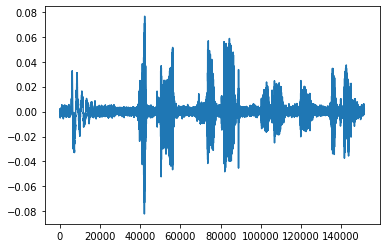

In [14]:
# Demonstrates the results of the load_wav_16k_mono
wave, sample_rate = load_wav_16k_mono('/content/drive/My Drive/Colab Notebooks/SummerProject/data/core-uxtd/core/01M/001B.wav')
plt.plot(wave)

plt.show()

In [15]:
# Create Train DF & Test DF
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [16]:
# Create test/train tensors

train_start_tensor = tf.data.Dataset.from_tensor_slices(train['Start'])
train_end_tensor = tf.data.Dataset.from_tensor_slices(train['End'])
train_file_tensor = tf.data.Dataset.from_tensor_slices(train['filepath'])
train_label_tensor = tf.data.Dataset.from_tensor_slices(train['Phoneme'])


test_start_tensor = tf.data.Dataset.from_tensor_slices(test['Start'])
test_end_tensor = tf.data.Dataset.from_tensor_slices(test['End'])
test_file_tensor = tf.data.Dataset.from_tensor_slices(test['filepath'])
test_label_tensor = tf.data.Dataset.from_tensor_slices(test['Phoneme'])

In [17]:
train_zip_data = tf.data.Dataset.zip((train_start_tensor, train_end_tensor, train_file_tensor, train_label_tensor))
test_zip_data = tf.data.Dataset.zip((test_start_tensor, test_end_tensor, test_file_tensor, test_label_tensor))

In [18]:
# This method loads the 16kHz wave, slices is where the phoneme is said, and then pads the utterance out to a second

def get_spectrogram_and_label(start, end, filepath, label):

  #Get full wave using load_wav_16k_mono
  wav, sample_rate = load_wav_16k_mono(filepath)

  #Slice the wave tensors by where the word starts and end
  start_index = start * tf.cast(sample_rate, dtype=('float64'))
  end_index = end * tf.cast(sample_rate, dtype=('float64'))
  wav = wav[int(start_index):int(end_index)]

  #Get the first 1 second of wav to standardize the size of the wave (1.5s*16000Hz=24000)
  wav = wav[:16000]

  #if wav shorter than 1 second, pad with zeros
  zero_padding = tf.zeros([16000]-tf.shape(wav), dtype=tf.float32)

  #Get spectrograms using tf.singal.stft()
  wav = tf.concat([zero_padding, wav], 0)                           
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)                
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)

  #Create multi-class labels using tf.math.argmax
  parts = tf.strings.split(input=label, sep="")
  label = parts[0]
  label_id = tf.math.argmax(label == phonemes)
  print(label_id)

  return spectrogram, label_id




Utterance Start:  5.48
Phoneme End:  5.76
/content/drive/My Drive/Colab Notebooks/SummerProject/data/core-uxtd/core/09F/002B.wav
T
tf.Tensor(22050, shape=(), dtype=int32) tf.Tensor(135168, shape=(), dtype=int32)
tf.Tensor(28, shape=(), dtype=int64)
tf.Tensor(28, shape=(), dtype=int64)
T


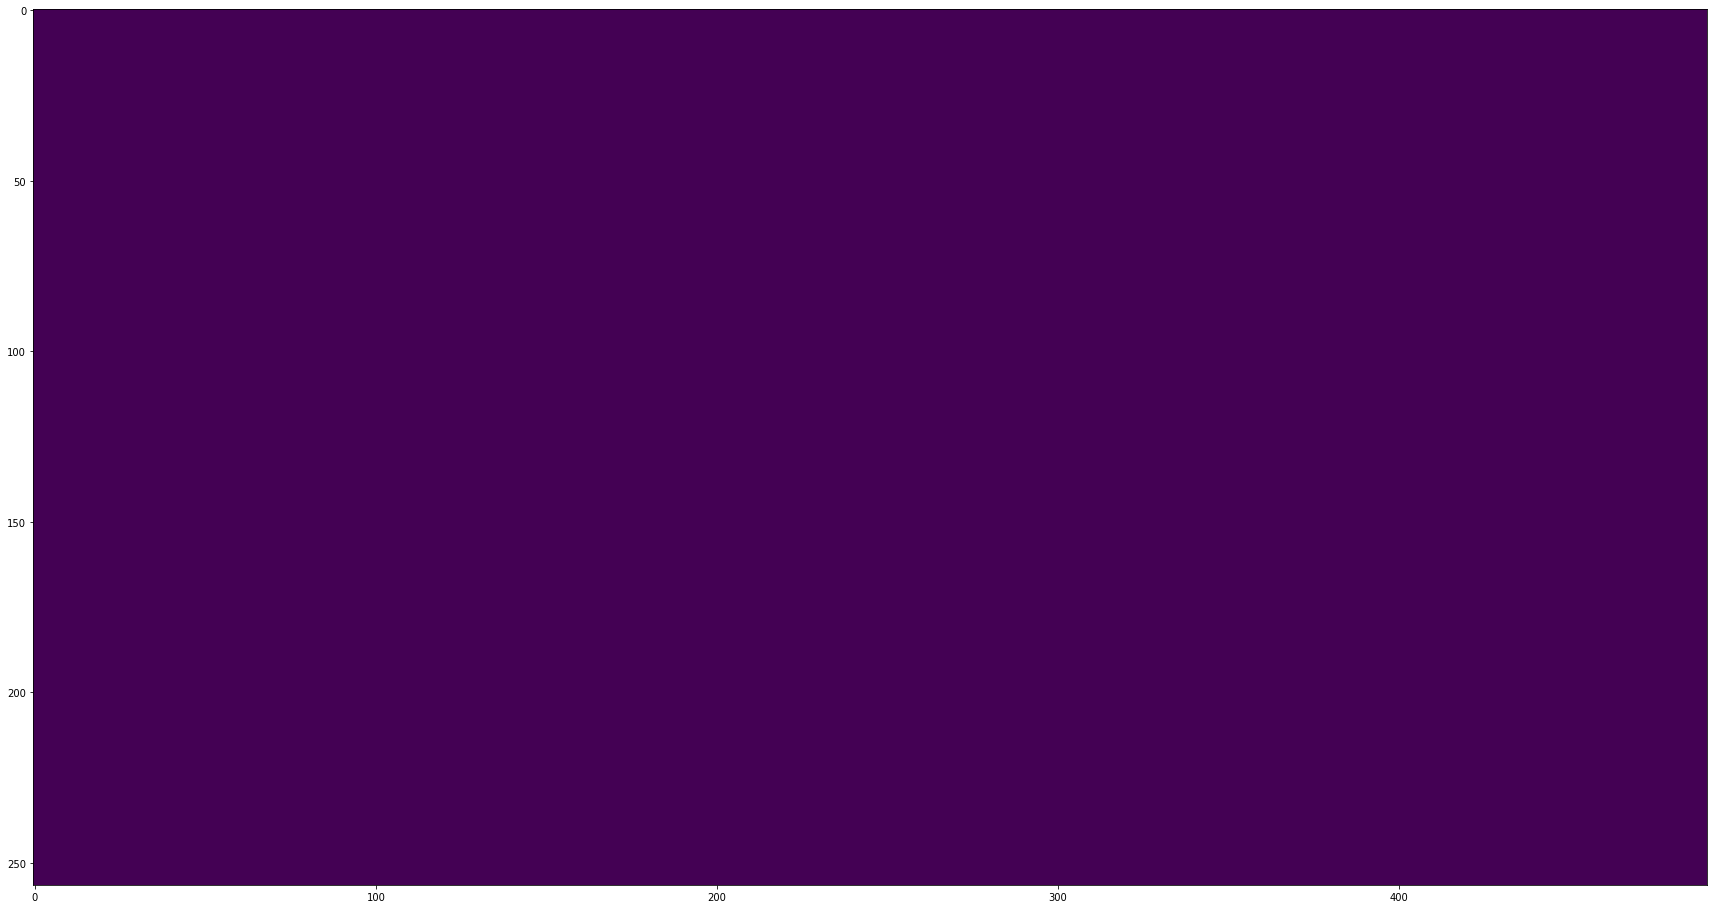

In [19]:
#Testing the pre-processing on a single data-point

start, end, filepath, label = train_zip_data.shuffle(buffer_size=10000).as_numpy_iterator().next()
print("Utterance Start: ", start)
print("Phoneme End: ", end)

filepath = filepath.decode("utf-8")
label = label.decode("utf-8")
print(filepath)
print(label)

#Get spectrogram of a single datapoint

spectrogram, label = get_spectrogram_and_label(start, end, filepath, label)

print(label)
print(phonemes[label.numpy()])

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Create the training and testing datasets by mapping the data through the get_spectrogram_and_label

In [20]:
# Transform train to spectrogram & label

train = train_zip_data.map(map_func=get_spectrogram_and_label)

train = train.cache()

train = train.shuffle(buffer_size=1000)

# Train in batches

train = train.batch(16)

train = train.prefetch(8)

Tensor("DecodeWav:1", shape=(), dtype=int32) Tensor("Size:0", shape=(), dtype=int32)


Tensor("ArgMax:0", shape=(), dtype=int64)


In [21]:
# transform test to spectrogram and label

test = test_zip_data.map(map_func=get_spectrogram_and_label)

test = test.cache()

test = train.shuffle(buffer_size=1000)

Tensor("DecodeWav:1", shape=(), dtype=int32) Tensor("Size:0", shape=(), dtype=int32)
Tensor("ArgMax:0", shape=(), dtype=int64)


We now want to start builing the model.

In [ ]:
# This gives us the input shape of the spectrogram and thus also the shape of the first convolutional layer

# for spec, _ in train.take(1):
#   input_shape = spec.shape

# print('Input Shape: ', input_shape)

In [22]:
# Building the model
num_labels = len(phonemes)
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))

# Add model saving
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/SummerProject/training_1/model_1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, period=5, verbose=1)


In [23]:
model.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 244, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 242, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 121, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 120032)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [26]:
# Train model using colab GPU

with tf.device('/device:GPU:0'):
  hist = model.fit(train, epochs=50, validation_data=test, callbacks=[model_callback])

model.save('/content/drive/My Drive/Colab Notebooks/SummerProject/my_model')


Epoch 1/50
1049/1049 [==============================] - 397s 301ms/step - loss: 3.3115 - accuracy: 0.1162 - val_loss: 3.1406 - val_accuracy: 0.1524
Epoch 2/50
1049/1049 [==============================] - 26s 25ms/step - loss: 3.1123 - accuracy: 0.1586 - val_loss: 3.0024 - val_accuracy: 0.1898
Epoch 3/50
1049/1049 [==============================] - 26s 25ms/step - loss: 2.9576 - accuracy: 0.1947 - val_loss: 2.8349 - val_accuracy: 0.2316
Epoch 4/50
1049/1049 [==============================] - 27s 25ms/step - loss: 2.7159 - accuracy: 0.2609 - val_loss: 2.5466 - val_accuracy: 0.3078
Epoch 5/50
1047/1049 [============================>.] - ETA: 0s - loss: 2.4123 - accuracy: 0.3420
Epoch 5: saving model to /content/drive/My Drive/Colab Notebooks/SummerProject/training_1/model_1.ckpt
1049/1049 [==============================] - 28s 26ms/step - loss: 2.4122 - accuracy: 0.3420 - val_loss: 2.3003 - val_accuracy: 0.3725
Epoch 6/50
1049/1049 [==============================] - 27s 25ms/step - loss: 

With a trained model, we can now create plots of the training metrics

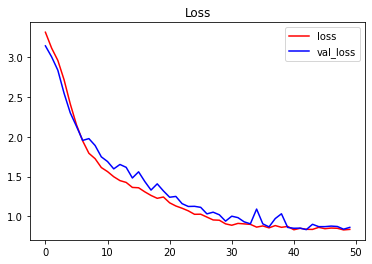

In [27]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(['loss', 'val_loss'])
plt.show()

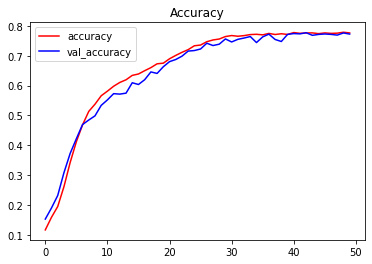

In [28]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# Create graphs in the same style as the word level models

plt.rcParams["figure.figsize"] = (16,20) #100

x = np.linspace(1, 50, 50)

fig, axs = plt.subplots(5, 2)

y = hist.history['val_loss']
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Loss')
axs[0, 0].set_ylabel('Phoneme')

y = hist.history['val_accuracy']
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Accuracy')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
# Create the diagram denoting the phoneme level model architecture

tf.keras.utils.plot_model(model, show_shapes=True)

Now we can test the model on some inputs

In [32]:
# Takes about 7 mins

test_audio = []
test_labels = []

for audio, label in test:
  test_audio.append(np.argmax(model.predict(audio.numpy()), axis=1))
  test_labels.append(label.numpy())

In [34]:
# This predicts the phoneme for each in a set of 16, we get an accuracy of 77%, which matches that found in training

flat_test_audio = [x for xs in test_audio for x in xs]
flat_test_labels = [x for xs in test_labels for x in xs]
c = (np.array(flat_test_audio) == np.array(flat_test_labels))
print("Accuracy: ", sum(c)/len(c))

Accuracy:  0.7729169150077483


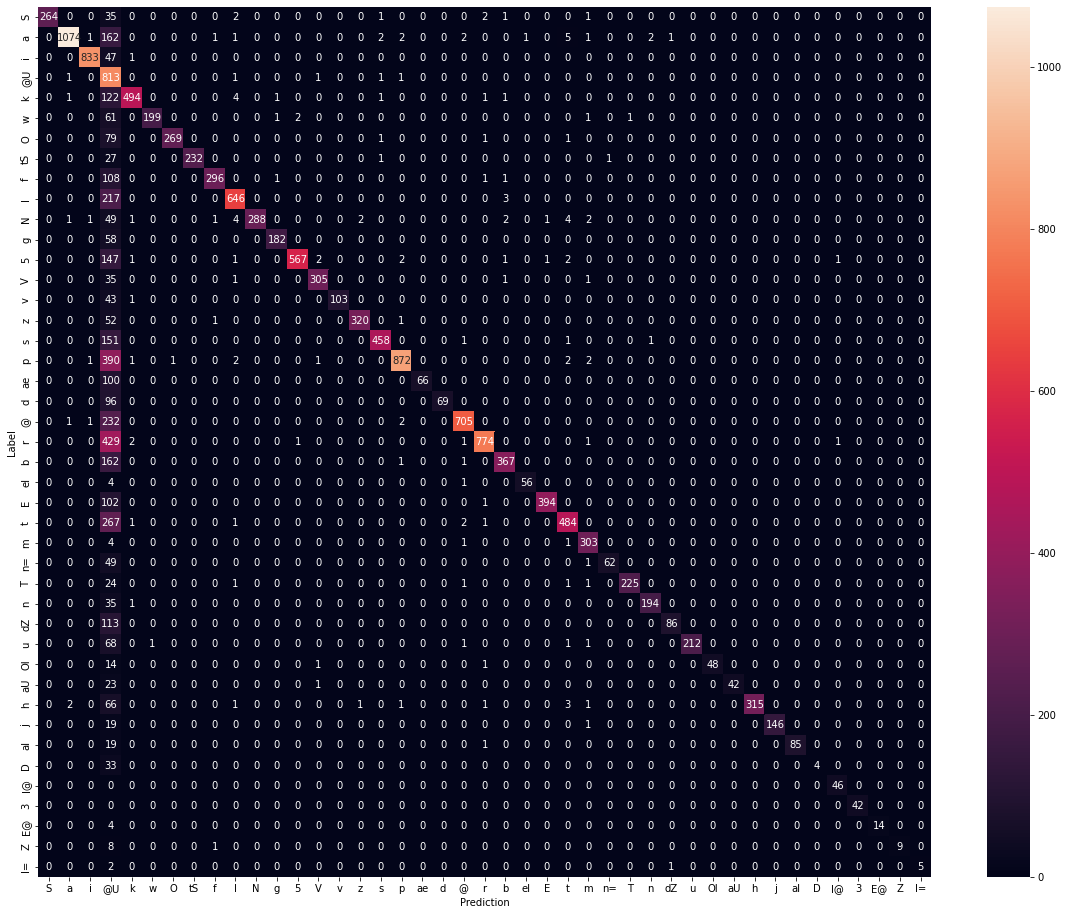

In [35]:
# Here we create a 43x43 confusion matrix using seaborn to better visualise the model's results

import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(flat_test_labels, flat_test_audio)
plt.figure(figsize=(20, 16))
sns.heatmap(confusion_mtx,
            xticklabels=phonemes,
            yticklabels=phonemes,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Below is an example of how a sliding window (slicing an input sample in set increments) may be used in practice


In [36]:
# Get full input speech sample

speech_path = '/content/drive/My Drive/Colab Notebooks/SummerProject/data/core-uxtd/core/01M/003B.wav'

In [37]:
# Preprocess the input speech as you would during deployment, return length of the utterance

import math

wav, sample_rate = load_wav_16k_mono(speech_path)

utterance_length = (math.ceil(wav.shape[0] / 16000))

print(utterance_length)

tf.Tensor(22050, shape=(), dtype=int32) tf.Tensor(159744, shape=(), dtype=int32)
8


In [38]:
# We defined a phoneme with 1 second, so split the utterance into 1 second chunks, then classify each chunk to a phoneme

start = [x for x in range(utterance_length)]
end = [x+1 for x in range(utterance_length)]
file_path = [speech_path for x in range(utterance_length)]

start_tensor = tf.data.Dataset.from_tensor_slices(start)
end_tensor = tf.data.Dataset.from_tensor_slices(end)
file_tensor = tf.data.Dataset.from_tensor_slices(file_path)

In [39]:
zip_data = tf.data.Dataset.zip((start_tensor, end_tensor, file_tensor))

In [40]:
def get_spectrogram_and_label_for_window(start, end, filepath):

  #Get full wav
  wav, sample_rate = load_wav_16k_mono(filepath)

  #Get wav only where phenome occurs
  start_index = start * tf.cast(sample_rate, dtype=('int32'))
  end_index = end * tf.cast(sample_rate, dtype=('int32'))
  wav = wav[int(start_index):int(end_index)]

  #Get the first 1 second of wav
  wav = wav[:16000]

  #if wav shorter than 1 second, pad with zeros
  zero_padding = tf.zeros([16000]-tf.shape(wav), dtype=tf.float32)

  wav = tf.concat([zero_padding, wav], 0)                           
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)                
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)

  return spectrogram


In [41]:
sliding_window_test = zip_data.map(map_func=get_spectrogram_and_label_for_window)

sliding_window_test = sliding_window_test.batch(16)

Tensor("DecodeWav:1", shape=(), dtype=int32) Tensor("Size:0", shape=(), dtype=int32)


In [42]:
sample = sliding_window_test.as_numpy_iterator().next()
sample.shape

(8, 491, 257, 1)

In [43]:
# Takes about 7 mins
predicted_phonemes = []

for audio in sliding_window_test:
  predicted_phonemes.append(np.argmax(model.predict(audio.numpy()), axis=1))

In [44]:
# Returns the eight predicted phonemes from the slicing window

phonemes[predicted_phonemes]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array(['p', 'r', 's', 'S', 'p', 'I@', '@U', '@U'], dtype=object)

In [45]:
# Shows the actual phoneme transcription 

label_path = '/content/drive/My Drive/Colab Notebooks/SummerProject/data/labels-uxtd-uxssd-upx/uxtd/phone_labels/lab/01M-003B.lab'
temp_df = pd.read_csv(label_path, sep=' ', index_col=None, header=0, names=["x","y","phone"])
temp_df["phone"]

0       t
1     sil
2       @
3       t
4       @
5     sil
6       i
7       t
8       i
9     sil
10     @U
11      t
12     @U
Name: phone, dtype: object

The sliding window predicted eight phonemes when there were really 12. What phonemes it did translate were wrong, apart from maybe the @U at the end of the utterance. This level of accuracy is not strong enough to be deployed.